In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [2]:
import json

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_path = '/home/donghyun/eye_writing_classification/v2_dataset/200_points_dataset/'

with open(data_path + 'eog_raw_numbers_200.json') as f:
  eog_raw_numbers = json.load(f)

with open(data_path + 'eog_eb_remove_numbers_200.json') as f:
  eog_eb_remove_numbers = json.load(f)

with open(data_path + 'eog_katakana_200.json') as f:
  eog_katakana = json.load(f)

with open(data_path + 'reference_data_200.json') as f:
  reference_data = json.load(f)


In [4]:
print("raw numbers")
print(eog_raw_numbers.keys())
print(np.array(eog_raw_numbers['0']).shape)
print(np.array(eog_raw_numbers['1']).shape)
print()
print('eye blink removed numbers')
print(eog_eb_remove_numbers.keys())
print(np.array(eog_eb_remove_numbers['0']).shape)
print(np.array(eog_eb_remove_numbers['1']).shape)
print()
print('katakana')
print(eog_katakana.keys())
print(np.array(eog_katakana['1']).shape)
print(np.array(eog_katakana['2']).shape)
print()
print('reference data')
print(reference_data.keys())
print('katakana classes : ', reference_data['katakana'].keys())
print('numbers classes : ', reference_data['numbers'].keys())
print(np.array(reference_data['katakana']['1']).shape)
print(np.array(reference_data['numbers']['1']).shape)

raw numbers
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
(54, 200, 2)
(54, 200, 2)

eye blink removed numbers
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
(54, 200, 2)
(54, 200, 2)

katakana
dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
(60, 200, 2)
(60, 200, 2)

reference data
dict_keys(['katakana', 'numbers'])
katakana classes :  dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
numbers classes :  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
(1, 200, 2)
(1, 200, 2)


### Data setting

In [5]:
# split train & test data
def train_test_split(data_dict, test_rate=0.2):
    classes = list(data_dict.keys())
    
    train_set = defaultdict(list)
    test_set = defaultdict(list)
    for cls in classes:
        values = np.array(data_dict[cls])

        n_test = int(len(values)*test_rate)
        n_train = int(len(values)-n_test)

        train_indices = np.random.choice(len(values),n_train,replace=False)
        test_indices = np.setdiff1d(range(len(values)), train_indices)

        train_set[int(cls)] = values[train_indices, :]
        test_set[int(cls)] = values[test_indices, :]

    return train_set, test_set

# train_dict, test_dict = train_test_split(eog_raw_numbers, 0.3)

# print(train_dict.keys())
# print(np.array(train_dict[0]).shape)
# print(np.array(test_dict[0]).shape)

In [6]:
### get train batch only real data & with reference data

def get_train_batch(data_dict, batch_size, n_batch, ref_dict=None, ref_key=None):
    classes = list(data_dict.keys())

    train_batch = []
    train_targets = []
    for n in range(n_batch):
        cls = np.random.randint(low=min(classes), high=max(classes), size=batch_size//2).tolist()
        pos_cls = cls
        neg_cls = [np.random.choice(np.setdiff1d(classes,cls[i]), size=1).item() for i in range(batch_size//2)]

        targets = np.ones((batch_size,))
        targets[batch_size // 2:] = 0

        pos_anchor_values = []
        neg_anchor_values = []
        pos_compar_values = []
        neg_compar_values = []
        for i in range(batch_size//2):

            pos_anchor_idx, neg_anchor_idx = np.random.choice(len(data_dict[cls[i]]), size=2)
            pos_compar_idx = np.random.choice(len(data_dict[pos_cls[i]]), size=1).item()
            neg_compar_idx = np.random.choice(len(data_dict[neg_cls[i]]), size=1).item()
            
            pos_anchor = data_dict[cls[i]][pos_anchor_idx]
            neg_anchor = data_dict[cls[i]][neg_anchor_idx]
            if ref_dict:
                # with reference data
                if n%2==0:
                    pos_value = np.array(ref_dict[ref_key][str(pos_cls[i])]).squeeze(axis=0)
                    neg_value = np.array(ref_dict[ref_key][str(neg_cls[i])]).squeeze(axis=0)
                else:
                    pos_value = data_dict[pos_cls[i]][pos_compar_idx]
                    neg_value = data_dict[neg_cls[i]][neg_compar_idx]
            else:
                # only real data
                pos_value = data_dict[pos_cls[i]][pos_compar_idx]
                neg_value = data_dict[neg_cls[i]][neg_compar_idx]

            pos_anchor_values.append(pos_anchor)
            neg_anchor_values.append(neg_anchor)
            pos_compar_values.append(pos_value)
            neg_compar_values.append(neg_value)

        anchors = np.concatenate([pos_anchor_values,neg_anchor_values])
        comparison = np.concatenate([pos_compar_values,neg_compar_values])
        pairs = list(np.array([anchors, comparison]))

        train_batch.append(pairs)             # (n_batch, pairs, batch_size, length, point)
        train_targets.append(targets)         # (n_batch, target)

    return train_batch, train_targets


# batch_size = 22
# n_batch=50
# train_batch_with_ref, train_targets_with_ref = get_train_batch(train_dict, batch_size, n_batch, reference_data, ref_key='numbers')

# print(np.array(train_batch_with_ref).shape)
# print(np.array(train_targets_with_ref).shape)

In [7]:
### get test batch
def get_test_batch(data_dict, ref_dict, ref_key):
    classes = list(data_dict.keys())
    n_class = len(classes)

    test_batch = []
    test_targets = []
    for cls in classes:
        for value in data_dict[cls]:
            anchors = np.array([value]*n_class)
            comparison = np.array(list(ref_dict[ref_key].values())).squeeze(axis=1)
            
            pairs = list(np.array([anchors, comparison]))
            targets = np.zeros((n_class,))
            if ref_key == 'katakana':
                targets[cls-1] = 1
            else:
                targets[cls] = 1

            test_batch.append(pairs)
            test_targets.append(targets)

    return test_batch, test_targets

# test_batch, test_targets = get_test_batch(test_dict, reference_data, ref_key='numbers')

# print(np.array(test_batch).shape)
# print(np.array(test_targets).shape)

### Visualization

In [8]:
def plot_images(input_list, task='train'):
  row, col, _, _ = np.array(input_list).shape
  fig,axes = plt.subplots(row,col, figsize=(col//row*4,row*2))
  n = 0
  for r in range(row):
    for c in range(col):
      x,y = zip(*input_list[r][c])

      axes[r][c].set_xlim([-1.2, 1.2])
      axes[r][c].set_ylim([-1.2, 1.2])
      axes[r][c].get_xaxis().set_visible(False)
      axes[r][c].get_yaxis().set_visible(False)

      if task=='test':
        axes[r][c].scatter(x,y, 1)
      else:
        if c >= col//2:
          axes[r][c].scatter(x,y, 1, color='red')
        else:
          axes[r][c].scatter(x,y, 1, color='blue')
  n += 1

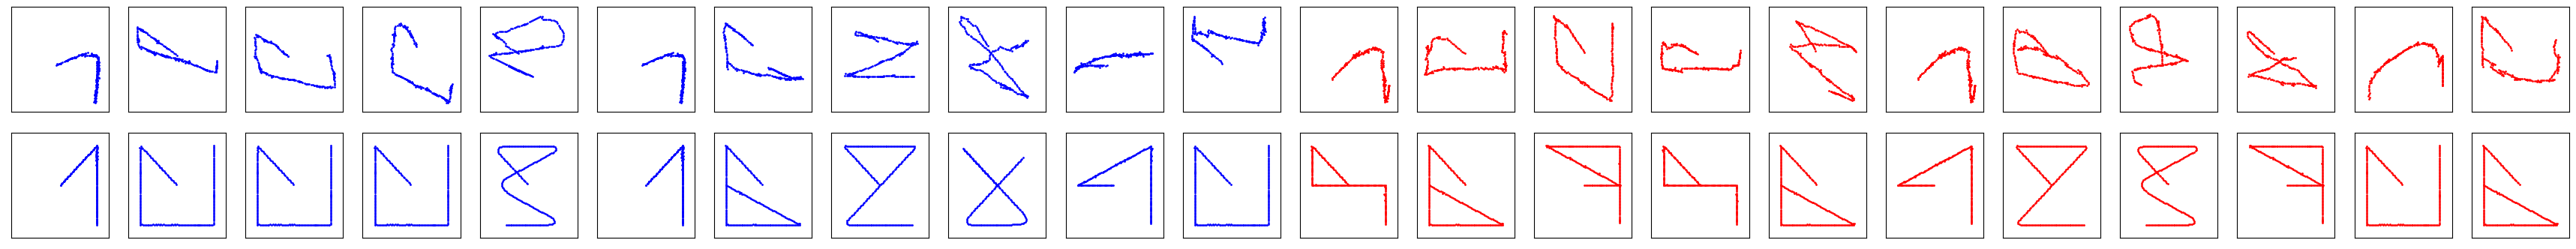

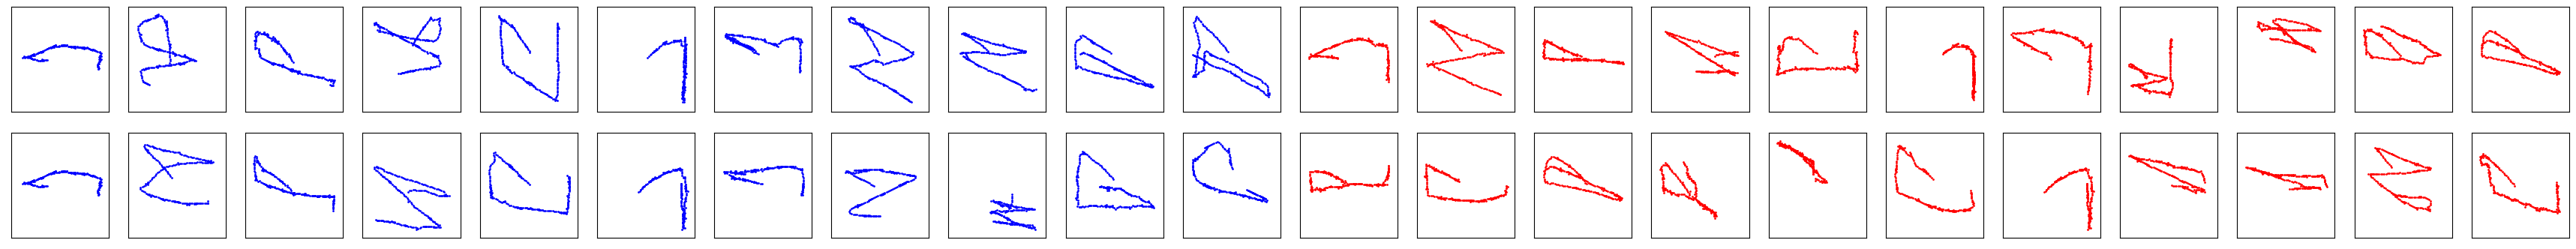

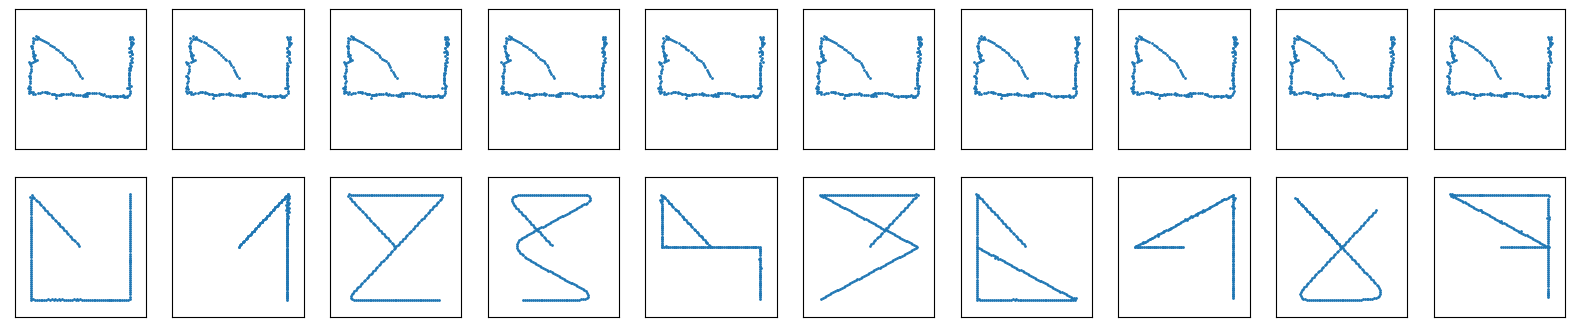

In [9]:
plot_images(train_batch_with_ref[0])
plot_images(train_batch_with_ref[1])
plot_images(test_batch[0], 'test')

### Model

In [9]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.layers import GlobalAveragePooling1D, BatchNormalization, Dropout
from tensorflow.keras.layers import Lambda, LayerNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

from attention import Attention

In [10]:
class ViTBaseModel():
    def __init__(self, input_shape, params):
        self.input_shape = input_shape
        self.batch_size = params['batch_size']

        self.hidden_size = params['hidden_size']
        self.heads = params['heads']
        self.dropout = params['dropout']
        self.mlp_dropout = params['mlp_dropout']
        self.mlp_units = params['mlp_units']
        self.n_layers = params['n_layers']
        self.patch_size = params['patch_size']

    def mlp(self, input):
        output_dim = input.shape[-1]
        x = input
        for dim in self.mlp_units:
            x = Dense(dim)(x)
            x = Dropout(self.mlp_dropout)(x)
        out = Dense(output_dim)(x)
        return out


    def msa(self, input):
        batch_size = input.shape[0]
        projection_dim = self.hidden_size // self.heads

        q = Dense(self.hidden_size)(input)
        q = tf.reshape(q, (batch_size, -1, self.heads, projection_dim))
        k = Dense(self.hidden_size)(input)
        k = tf.reshape(k, (batch_size, -1, self.heads, projection_dim))
        v = Dense(self.hidden_size)(input)
        v = tf.reshape(v, (batch_size, -1, self.heads, projection_dim))

        score = tf.matmul(q,k, transpose_b=True)
        score = score / k.shape[-1]**(1/2)
        weights = softmax(score)
        attn_score = tf.matmul(weights, v)

        out = tf.transpose(attn_score, perm=[0,2,1,3])
        out = tf.reshape(out, (batch_size, -1, self.hidden_size))
        out = Dense(self.hidden_size)(out)

        return out


    def encoder_block(self, input):
        res = input
        x = LayerNormalization(epsilon=1e-6)(input)
        x = self.msa(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dropout(self.dropout)(x)
        x += res

        out = self.mlp(x)
        out = LayerNormalization(epsilon=1e-6)(x)
        return out


    def transformer_encoder(self, input):
        x = input
        for i in range(self.n_layers):
            x = self.encoder_block(x)
        
        out = LayerNormalization(epsilon=1e-6)(x)
        return out


    def model(self):
        input_ = Input(shape = self.input_shape)        # (None, length, points)

        emb = Conv1D(filters=self.hidden_size, kernel_size=(self.patch_size,), strides=(self.patch_size,))(input_)  # patches : (None, length, points) -> (None, n_patch, dim)
        emb = tf.reshape(emb, [self.batch_size, emb.shape[1], emb.shape[2]])                                        # (None, n_patch, dim) -> (batch_size, n_patch, dim))

        cls_tokens = tf.Variable(initial_value=tf.random.normal([1, self.hidden_size]))             # (1, dim)
        cls_tokens = tf.convert_to_tensor([cls_tokens]*emb.shape[0])                                # (batch_size, 1, dim)
        x = tf.concat([cls_tokens, emb], axis=1)        # (batch_size, cls_tokens + n_patch, dim)

        pos_embedding = tf.Variable(initial_value=tf.random.normal([1, x.shape[1], self.hidden_size]))      # (1, cls_tokens + n_patch, dim)
        x += pos_embedding                              # (batch_size, cls_tokens + n_patch, dim)

        x = self.transformer_encoder(x)                 # (batch_size, cls_tokens + n_patch, output_dim)
        
        output_ = x[:,0,:]                              # (batch_size, cls_token, output_dim)

        model_ = Model(inputs = input_, outputs = output_)
        return model_


class HybridBaseModel():
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def model(self):
        input_ = Input(self.input_shape, name = "Input")

        X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu',name = "Conv_1")(input_)
        X = BatchNormalization(name = "Conv_1_Batch_norm")(X)
        X = Dropout(rate = 0.2, name = "Conv_1_Dropout")(X)

        X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu',name = "Conv_2")(X)      
        X = BatchNormalization(name = "Conv_2_Batch_norm")(X)
        X = Dropout(rate = 0.2,name = "Conv_2_Dropout")(X)

        X = LSTM(units = 64, return_sequences = True, name = "LSTM_1")(X)
        X = BatchNormalization(name = "LSTM_1_Batch_norm")(X)
        X = Dropout(rate = 0.2,name = "LSTM_1_Dropout")(X)
        
        X = LSTM(units = 64, return_sequences = True, name = "LSTM_2")(X)
        X = Attention(32)(X)
        X = BatchNormalization(name = "LSTM_2_Batch_norm")(X)
        X = Dropout(rate = 0.2,name = "LSTM_2_Dropout")(X)
        
        output_ = Dense(128)(X)

        model_ = Model(inputs = input_, outputs = output_)

        return model_

In [11]:
def binary_siamese_net(input_shape, base_model):
  left_input = Input(input_shape, name= "Left Input")
  right_input = Input(input_shape, name= "Right Input")

  encoded_left = base_model(left_input)
  encoded_right = base_model(right_input)

  L1_layer = Lambda(lambda tensor: K.abs(tensor[0]-tensor[1]))
  L1_distance = L1_layer([encoded_left,encoded_right])

  prediction = Dense(1, activation = 'sigmoid',name = "Dense")(L1_distance)

  model = Model(inputs = [left_input, right_input], outputs = prediction)

  return model

In [12]:
tf.keras.backend.clear_session()

In [13]:
# ViT base model

input_shape = (200,2)    # (length, points)
params = {'hidden_size':32,
          'batch_size':10,            # fix : must be equaled with number of test pairs 
          'attn_dim': 4,
          'patch_size':10,
          'heads':4,
          'n_layers':4,
          'mlp_units':[512,256,128],
          'dropout':0,
          'mlp_dropout':0
          }

ViT = ViTBaseModel(input_shape, params)
model = binary_siamese_net(input_shape, base_model = ViT.model())

optimizer = Adam(learning_rate = 0.001)
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['acc'])

model.summary()

2022-12-23 15:21:54.132759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 15:21:54.132900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 15:21:54.132976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 15:21:54.133184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 15:21:54.133264: I tensorflow/compiler/xla/stream_executo

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Left Input (InputLayer)        [(None, 200, 2)]     0           []                               
                                                                                                  
 Right Input (InputLayer)       [(None, 200, 2)]     0           []                               
                                                                                                  
 model (Functional)             (10, 32)             18400       ['Left Input[0][0]',             
                                                                  'Right Input[0][0]']            
                                                                                                  
 lambda (Lambda)                (10, 32)             0           ['model[0][0]',            

In [14]:
# CNN + LSTM + Hierarchical attention base model

input_shape = (200,2)                   # (length, point)
Hybrid = HybridBaseModel(input_shape)
base_model = Hybrid.model()
model = binary_siamese_net(input_shape, base_model)

optimizer = Adam(learning_rate = 0.001)
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['acc'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Left Input (InputLayer)        [(None, 200, 2)]     0           []                               
                                                                                                  
 Right Input (InputLayer)       [(None, 200, 2)]     0           []                               
                                                                                                  
 model_2 (Functional)           (None, 128)          92160       ['Left Input[0][0]',             
                                                                  'Right Input[0][0]']            
                                                                                                  
 lambda_1 (Lambda)              (None, 128)          0           ['model_2[0][0]',          

### Experiments

In [15]:
def learn(model, train_batch, train_targets):    
    acc = 0.0
    loss = 0.0
    i = 0
    for batch in zip(train_batch, train_targets):
        data, target = batch

        batch_metrics = model.train_on_batch(data, target)

        acc += batch_metrics[1]
        loss += batch_metrics[0]
        i+=1

    acc = (acc/i)*100
    loss = (loss/i)
    return acc, loss

def evaluate(model, test_batch, test_targets):
    # memo = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0}
    correct = 0
    i = 0
    for batch in zip(test_batch, test_targets):
        data, target = batch

        probs = model.predict_on_batch(data)
            
        if np.argmax(probs) == np.argmax(target):
            # memo[str(np.argmax(target))] += 1
            correct +=1
        i+=1

    acc = (correct/i)*100
    return acc

In [16]:
def experiment(cfg, real_data, reference_data):

    # data setting
    train_dict, test_dict = train_test_split(real_data, cfg.split_ratio)
    test_batch, test_targets = get_test_batch(test_dict, reference_data, ref_key=cfg.ref_key)

    # model setting
    input_shape = test_batch[0][0][0].shape                # (length, points)

    if cfg.model_type == 'HybridBaseModel':
        base_model = HybridBaseModel(input_shape)
    else:
        base_model = ViTBaseModel(input_shape, cfg.ViT_params)

    model = binary_siamese_net(input_shape, base_model.model())

    # hyperparameters setting
    if cfg.model_type == 'HybridBaseModel':
        optimizer = Adam(learning_rate = 0.001)
    else: 
        optimizer = Adam(learning_rate = 0.0005)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['acc'])

    # learn & evaluate
    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    for e in range(cfg.epochs):

        train_batch, train_targets = get_train_batch(train_dict, cfg.batch_size, cfg.n_batch, reference_data, ref_key=cfg.ref_key)
        train_acc, train_loss = learn(model, train_batch, train_targets)
        test_acc = evaluate(model, test_batch, test_targets)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        test_acc_list.append(test_acc)

        print('epoch : {}, train acc : {:.4f} %, train loss : {:.8f}, test acc : {:.4f} %, '.format(e+1, train_acc, train_loss, test_acc))

        # if e == cfg.epochs-1:
        #     for k in memo.keys():
        #         print('class {} : ({}/{})'.format(k, memo[k], 16))
        
    return train_acc_list, train_loss_list, test_acc_list

In [17]:
class Config:
    split_ratio = 0.3
    ref_key = 'numbers'
    batch_size = 18                            # fix : not should be equaled with number of test pairs 
    n_batch = 10
    model_type = 'HybridBaseModel'
    ViT_params = {'hidden_size':128,
                   'batch_size':10,            # fix : must be equaled with number of test pairs 
                   'patch_size':10,
                   'heads':4,
                   'n_layers':4,
                   'mlp_units':[512,256,128],
                   'dropout':0,
                   'mlp_dropout':0
                    }
    epochs = 10

cfg = Config()
train_acc_list, train_loss_list, test_acc_list = experiment(cfg, eog_eb_remove_numbers, reference_data)

2022-12-23 15:22:03.602246: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1740 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 22843883520 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-12-23 15:22:03.602314: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3

epoch : 1, train acc : 57.7778 %, train loss : 0.72934198, test acc : 28.7500 %, 
epoch : 2, train acc : 61.1111 %, train loss : 0.62967079, test acc : 28.1250 %, 
epoch : 3, train acc : 71.6667 %, train loss : 0.55256438, test acc : 23.7500 %, 
epoch : 4, train acc : 67.2222 %, train loss : 0.57894801, test acc : 27.5000 %, 
epoch : 5, train acc : 70.0000 %, train loss : 0.56970388, test acc : 31.2500 %, 
epoch : 6, train acc : 72.2222 %, train loss : 0.53037060, test acc : 31.8750 %, 
epoch : 7, train acc : 71.6667 %, train loss : 0.55450192, test acc : 27.5000 %, 
epoch : 8, train acc : 78.3333 %, train loss : 0.45746287, test acc : 26.2500 %, 
epoch : 9, train acc : 76.6667 %, train loss : 0.50349658, test acc : 30.6250 %, 
epoch : 10, train acc : 71.6667 %, train loss : 0.57968761, test acc : 30.0000 %, 


In [18]:
class Config:
    split_ratio = 0.3
    ref_key = 'numbers'
    batch_size = 10            # fix : must be equaled with number of test pairs 
    n_batch = 10
    model_type = 'ViTBaseModel'
    ViT_params = {'hidden_size':128,
                   'batch_size':10,            # fix : must be equaled with number of test pairs 
                   'patch_size':10,
                   'heads':4,
                   'n_layers':4,
                   'mlp_units':[512,256,128],
                   'dropout':0,
                   'mlp_dropout':0
                    }
    epochs = 10

cfg = Config()
train_acc_list, train_loss_list, test_acc_list = experiment(cfg, eog_eb_remove_numbers, reference_data)

epoch : 1, train acc : 59.0000 %, train loss : 0.70394720, test acc : 29.3750 %, 
epoch : 2, train acc : 57.0000 %, train loss : 0.62568595, test acc : 45.6250 %, 
epoch : 3, train acc : 70.0000 %, train loss : 0.54399440, test acc : 45.0000 %, 
epoch : 4, train acc : 77.0000 %, train loss : 0.50713484, test acc : 43.1250 %, 
epoch : 5, train acc : 69.0000 %, train loss : 0.59197798, test acc : 45.0000 %, 
epoch : 6, train acc : 72.0000 %, train loss : 0.50626031, test acc : 41.8750 %, 
epoch : 7, train acc : 74.0000 %, train loss : 0.51512467, test acc : 34.3750 %, 
epoch : 8, train acc : 80.0000 %, train loss : 0.46647426, test acc : 45.0000 %, 
epoch : 9, train acc : 83.0000 %, train loss : 0.44504796, test acc : 43.7500 %, 
epoch : 10, train acc : 76.0000 %, train loss : 0.50794725, test acc : 28.1250 %, 


In [19]:
class Config:
    split_ratio = 0.3
    ref_key = 'katakana'
    batch_size = 12                            # fix : must be equaled with number of test pairs 
    n_batch = 10
    model_type = 'ViTBaseModel'
    ViT_params = {'hidden_size':128,
                   'batch_size':12,            # fix : must be equaled with number of test pairs 
                   'patch_size':10,
                   'heads':4,
                   'n_layers':4,
                   'mlp_units':[512,256,128],
                   'dropout':0,
                   'mlp_dropout':0
                    }
    epochs = 10

cfg = Config()
train_acc_list, train_loss_list, test_acc_list = experiment(cfg, eog_katakana, reference_data)

epoch : 1, train acc : 59.1667 %, train loss : 0.65697776, test acc : 37.0370 %, 
epoch : 2, train acc : 58.3333 %, train loss : 0.59172412, test acc : 50.0000 %, 
epoch : 3, train acc : 72.5000 %, train loss : 0.54209362, test acc : 38.4259 %, 
epoch : 4, train acc : 67.5000 %, train loss : 0.58150772, test acc : 26.8519 %, 
epoch : 5, train acc : 66.6667 %, train loss : 0.58401870, test acc : 49.0741 %, 
epoch : 6, train acc : 65.8333 %, train loss : 0.55625749, test acc : 43.0556 %, 
epoch : 7, train acc : 70.8333 %, train loss : 0.50722439, test acc : 43.9815 %, 
epoch : 8, train acc : 66.6667 %, train loss : 0.57312402, test acc : 48.6111 %, 
epoch : 9, train acc : 77.5000 %, train loss : 0.53510820, test acc : 45.3704 %, 
epoch : 10, train acc : 73.3333 %, train loss : 0.51849973, test acc : 52.3148 %, 


In [20]:
class Config:
    split_ratio = 0.3
    ref_key = 'katakana'
    batch_size = 12                      # fix : not should be equaled with number of test pairs 
    n_batch = 10
    model_type = 'HybridBaseModel'
    ViT_params = {'hidden_size':128,
                   'batch_size':12,            # fix : must be equaled with number of test pairs 
                   'patch_size':10,
                   'heads':4,
                   'n_layers':4,
                   'mlp_units':[512,256,128],
                   'dropout':0,
                   'mlp_dropout':0
                    }
    epochs = 10

cfg = Config()
train_acc_list, train_loss_list, test_acc_list = experiment(cfg, eog_katakana, reference_data)

2022-12-23 15:23:44.543402: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1740 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 22843883520 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-12-23 15:23:44.543468: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3

epoch : 1, train acc : 50.0000 %, train loss : 0.75719392, test acc : 14.8148 %, 
epoch : 2, train acc : 53.3333 %, train loss : 0.71167978, test acc : 18.0556 %, 
epoch : 3, train acc : 59.1667 %, train loss : 0.66474091, test acc : 28.7037 %, 
epoch : 4, train acc : 59.1667 %, train loss : 0.65800596, test acc : 27.7778 %, 
epoch : 5, train acc : 65.0000 %, train loss : 0.58334635, test acc : 29.6296 %, 
epoch : 6, train acc : 62.5000 %, train loss : 0.65275446, test acc : 26.8519 %, 
epoch : 7, train acc : 70.0000 %, train loss : 0.57742737, test acc : 25.9259 %, 
epoch : 8, train acc : 59.1667 %, train loss : 0.67865390, test acc : 19.4444 %, 
epoch : 9, train acc : 70.0000 %, train loss : 0.58510395, test acc : 18.9815 %, 
epoch : 10, train acc : 66.6667 %, train loss : 0.57826104, test acc : 19.4444 %, 


#### Visualrization

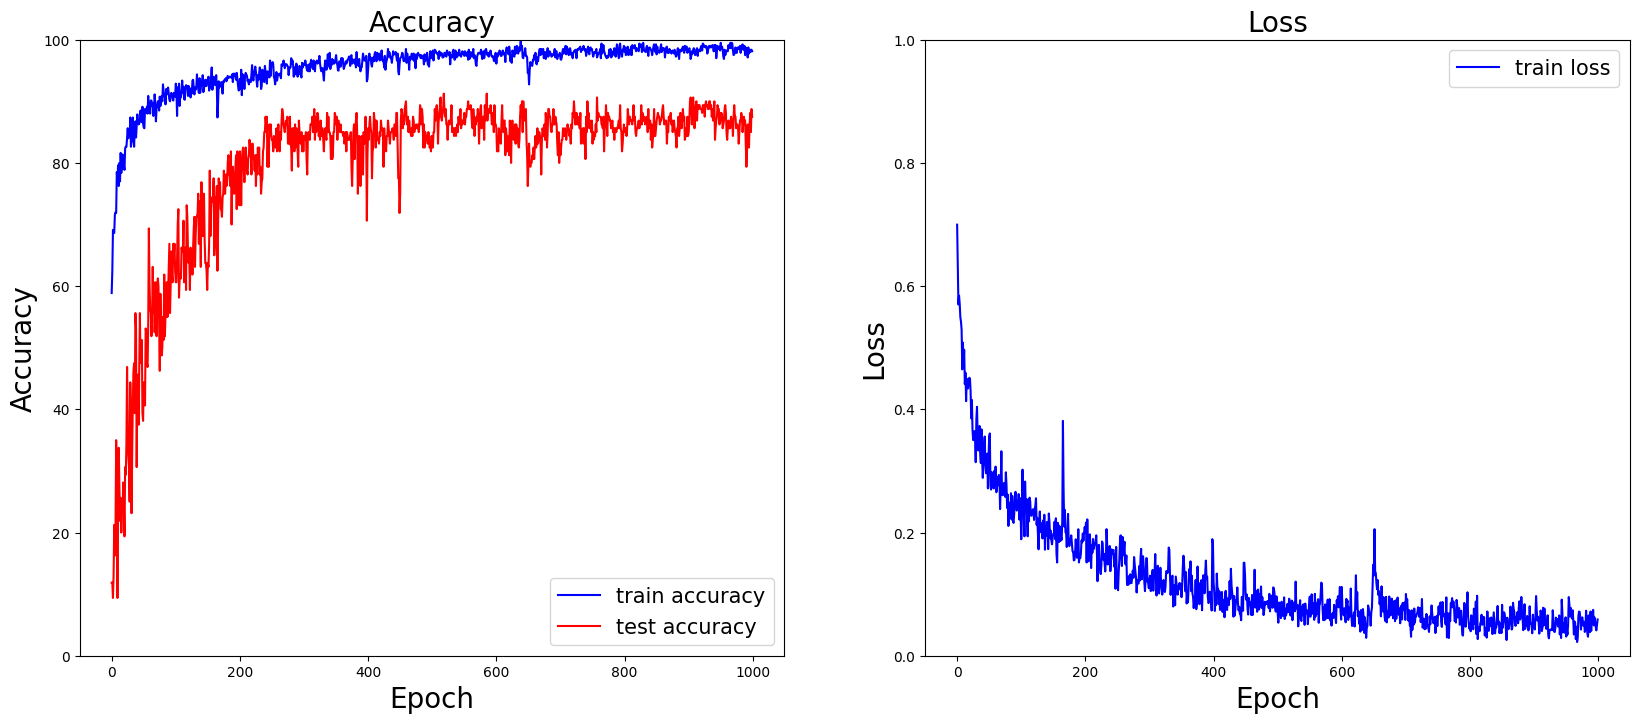

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize = (20,8))

# accuracy
axes[0].plot(train_acc_list, c = 'b', linestyle = 'solid', linewidth = 1.5)
axes[0].plot(test_acc_list, c = 'r', linestyle = 'solid', linewidth = 1.5)

axes[0].set_ylim(0,100)

axes[0].set_title("Accuracy", fontsize=20)
axes[0].set_xlabel('Epoch', fontsize = 20)
axes[0].set_ylabel('Accuracy', fontsize = 20)

axes[0].legend(['train accuracy', 'test accuracy'], fontsize = 15)

# train loss 
axes[1].plot(train_loss_list, c = 'b', linestyle = 'solid', linewidth = 1.5)

axes[1].set_ylim(0,1)

axes[1].set_title("Loss", fontsize = 20)
axes[1].set_xlabel('Epoch', fontsize = 20)
axes[1].set_ylabel('Loss', fontsize = 20)

axes[1].legend(['train loss'], fontsize = 15)

# plot
plt.show()